In [1]:
# functions 
def read_preprocess(): # file_path,columns_selected,replace_NA,replace_negative
    # libraries required
    import pandas as pd
    # read file
    df = pd.read_csv(file_path)
    # selecting station #8779,#8780,#8781 #18644
    df = df.loc[(df['Station Name'] == "#Stockholm Sveavägen 59 Gata") |
                (df['Station Name'] == "#Stockholm Hornsgatan 108 Gata") |
                (df['Station Name'] == "#Stockholm Torkel Knutssongatan") | 
                (df['Station Name'] == "#Stockholm E4/E20 Lilla Essingen")]
    
    # convert columns to date
    df['DateTimestamp'] = pd.to_datetime(df['DateTimestamp'])
    # Generating Year
    df['Year'] = df['DateTimestamp'].dt.year
    # drop 2020 data
    df = df[df['Year'] !=  2020]
    # selectin years of data
    df = df.loc[df['Year'].isin([2016,2017,2018,2019])]
    # select only the mentioned columns
    df = df[columns_selected]
    
    if replace_NA == True:
        # replace na with zero
        df = df.fillna(0)
    
    if replace_negative == True:
        # select float columns apart from Air tempterature
        columns_to_remove_negative = df.select_dtypes(include=['float64']).columns[df.select_dtypes(include=['float64']).columns != 'Air temperature']
        # replace negative with zero
        temp = df[columns_to_remove_negative].copy()
        temp[temp<0] = 0
        df[columns_to_remove_negative] = temp

    return(df)

def add_features(df_1):
    # libraries required
    import pandas as pd
    # Generating weektype from day of week
    df_2 = df_1.copy()
    df_2['Weektype'] = pd.DatetimeIndex(df_2['DateTimestamp']).dayofweek
    # Replace weedays labels WeekDays and WeekEnds 
    df_2['Weektype'] = df_2['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
    df_2['Weektype'] = df_2['Weektype'].replace([5, 6], 'WeekEnd')
    # Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
    df_3 = df_2.copy()
    df_3 = df_3.assign(Hour=pd.cut(df_3['DateTimestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
    # Replace timestamp 00:00 with Transition
    df_3['Hour'] = df_3['Hour'].fillna('Transition')
    df_3['Hour'] = df_3.Hour.astype(str)
    ## onehot encoding catergories column
    # Get dummies
    df_4 = pd.get_dummies(df_3)
    return(df_4)

def Generate_scale_train_test(data_set_scaled,data_segments_shape,y_features_column_index,selected_stations,lag):
    import numpy as np
    
    Train_X = []
    Train_y = []
    Valid_X = []
    Valid_y = []
    Test_X = []
    Test_y = []
    
    for i in range(0,len(selected_stations)):
        
        print('Processing data for station: ',selected_stations[i])
        # select stationwise data return only values
        station_data_set = data_set_scaled[data_set_scaled[selected_stations[i]] == 1].values
        
        ## Generating Features and predictions
        X = station_data_set[0:len(station_data_set)-lag,:]
        y = station_data_set[lag:len(station_data_set),y_features_column_index]

        print("X and Y:--")
        print("X Shape: ",X.shape)
        print("Y Shape: ",y.shape)
        print()

        ## splitting data into test, valid and train
        X_train = X[0:data_segments_shape[0]]
        y_train = y[0:data_segments_shape[0]]

        X_valid = X[data_segments_shape[0]:data_segments_shape[0]+data_segments_shape[1]]
        y_valid = y[data_segments_shape[0]:data_segments_shape[0]+data_segments_shape[1]]

        X_test = X[data_segments_shape[0]+data_segments_shape[1]:data_segments_shape[0]+
                   data_segments_shape[1]+data_segments_shape[2]]
        y_test = y[data_segments_shape[0]+data_segments_shape[1]:data_segments_shape[0]+
                   data_segments_shape[1]+data_segments_shape[2]]

        print("X/y_train, X/y_valid and X/y_train:--")
        print("X_train_shape: ",X_train.shape)
        print("y_train_shape: ",y_train.shape)
        print("X_valid_shape: ",X_valid.shape)
        print("y_valid_shape: ",y_valid.shape)
        print("X_test_shape: ",X_test.shape)
        print("y_test_shape: ",y_test.shape)
        print()

        print("X/y_Train, X/y_Valid and Y_Train 3D [samples, timesteps, features]:--")
        ## reshape input to be 3D [samples, timesteps, features] 
        
        # reshaping train
        X_Train = []
        y_Train = []

        for i in range(lag,len(X_train)+lag,lag):
            X_Train.append(X_train[i-lag:i])
            y_Train.append(y_train[i-lag:i])

        X_Train = np.array(X_Train)
        y_Train = np.array(y_Train)

        print("X_Train_shape: ",X_Train.shape)
        print("y_Train_shape: ",y_Train.shape)

        # reshaping valid
        X_Valid = []
        y_Valid = []

        for i in range(lag,len(X_valid)+lag,lag):
            X_Valid.append(X_valid[i-lag:i])
            y_Valid.append(y_valid[i-lag:i])

        X_Valid = np.array(X_Valid)
        y_Valid = np.array(y_Valid)

        print("X_Valid_shape: ",X_Valid.shape)
        print("y_Valid_shape: ",y_Valid.shape)

        # reshaping test
        X_Test = []
        y_Test = []

        for i in range(lag,len(X_test)+lag,lag):
            X_Test.append(X_test[i-lag:i])
            y_Test.append(y_test[i-lag:i])

        X_Test = np.array(X_Test)
        y_Test = np.array(y_Test)

        print("X_Test_shape: ",X_Test.shape)
        print("y_Test_shape: ",y_Test.shape)
        print()
        
        Train_X.append(X_Train)
        Train_y.append(y_Train)
        Valid_X.append(X_Valid)
        Valid_y.append(y_Valid)
        Test_X.append(X_Test)
        Test_y.append(y_Test)
        
        print("Train_X_shape: ",np.array(Train_X).shape)
        print("Train_y_shape: ",np.array(Train_y).shape)
        print("Valid_X_shape: ",np.array(Valid_X).shape)
        print("Valid_y_shape: ",np.array(Valid_y).shape)
        print("Test_X_shape: ",np.array(Test_X).shape)
        print("Test_y_shape: ",np.array(Test_y).shape)
        print()
    
    # convert list to numpy array
    Train_X=np.array(Train_X)
    Train_y=np.array(Train_y)
    Valid_X=np.array(Valid_X)
    Valid_y=np.array(Valid_y)
    Test_X=np.array(Test_X)
    Test_y=np.array(Test_y)
    
    return(Train_X,Train_y,Valid_X,Valid_y,Test_X,Test_y)

def LSTM_model(X_Train,lag,lstm_units,drop_out):
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    from keras.layers import Reshape
    #from keras.layers import Masking

    ## LSTM Architecture
    # input layer
    model = Sequential()
    # Masking Layer
    #model.add(Masking(mask_value=0))
    # 1
    model.add(LSTM(units=lstm_units,return_sequences = True,input_shape=(np.shape(X_Train)[1],np.shape(X_Train)[2])))
    model.add(Dropout(drop_out))
    # 2
    model.add(LSTM(units=lstm_units,return_sequences = False))
    model.add(Dropout(drop_out))
    # output layer
    model.add(Dense(lag*4))
    # reshape layer
    model.add(Reshape((lag,4)))
    # model architecture
    model.summary()
    
    return(model)

def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

def smape_loss(true,predicted):
    # Import Keras backend
    import keras.backend as K
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

In [2]:
file_path = r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData_metrologicalData.csv"
columns_selected = ['DateTimestamp','NO2','NOX as NO2','Black Carbon','O3','CO',
                    'PM2.5','PM10','Classification','Station Name','Air temperature']

# ,'Air pressure','Air temperature','Amount of clouds','Precipitation amount','Wind direction','Wind speed'
replace_NA = True
replace_negative = True

df = read_preprocess() # file_path,columns_selected,replace_NA,replace_negative

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140256 entries, 78836 to 450634
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   DateTimestamp    140256 non-null  datetime64[ns]
 1   NO2              140256 non-null  float64       
 2   NOX as NO2       140256 non-null  float64       
 3   Black Carbon     140256 non-null  float64       
 4   O3               140256 non-null  float64       
 5   CO               140256 non-null  float64       
 6   PM2.5            140256 non-null  float64       
 7   PM10             140256 non-null  float64       
 8   Classification   140256 non-null  object        
 9   Station Name     140256 non-null  object        
 10  Air temperature  140256 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 12.8+ MB
None


,NO2,NOX as NO2,Black Carbon,O3,CO,PM2.5,PM10,Air temperature
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,27.838517,57.777262,0.254945,18.620887,0.158407,5.346682,18.866842,8.437894
std,22.329940,64.937121,0.510221,26.362952,0.268008,4.720126,20.427424,8.292722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.700000
25%,10.100000,13.300000,0.000000,0.000000,0.000000,2.200000,7.600000,1.700000
50%,22.100000,34.800000,0.000000,0.000000,0.000000,4.300000,13.100000,7.400000
75%,40.000000,79.000000,0.297000,37.800000,0.300000,7.200000,22.400000,15.300000
max,212.800000,982.500000,30.400000,151.200000,20.700000,105.000000,365.100000,32.500000


In [3]:
# generate more features from raw data and generat dummies
df = add_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140256 entries, 78836 to 450634
Data columns (total 21 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   DateTimestamp                                  140256 non-null  datetime64[ns]
 1   NO2                                            140256 non-null  float64       
 2   NOX as NO2                                     140256 non-null  float64       
 3   Black Carbon                                   140256 non-null  float64       
 4   O3                                             140256 non-null  float64       
 5   CO                                             140256 non-null  float64       
 6   PM2.5                                          140256 non-null  float64       
 7   PM10                                           140256 non-null  float64       
 8   Air temperature                         

In [4]:
import pandas as pd

# create train test partition
temp = df.set_index(df['DateTimestamp'])
temp = temp.sort_index()
train = temp['2016-01-01 00:00:00':'2018-12-31 23:59:59']
valid = temp['2019-01-01 00:00:00':'2019-09-29 23:59:59']
test  = temp['2019-09-30 00:00:00':'2019-12-31 23:59:59']
print('Train Dataset:',train.shape)
print('Validate Dataset:',valid.shape)
print('Test Dataset:',test.shape)
from sklearn.preprocessing import MinMaxScaler

# select columns to reshape and normalise
datetime_column = df['DateTimestamp']
data_set = df.drop('DateTimestamp',axis=1)
print("Selected Column Shape: ",data_set.shape)
# column names to revert to data frame
data_set_column_names = data_set.columns

# MinMax Normalisation of Data (0,1)
x = data_set.values
min_max_scaler = MinMaxScaler(feature_range = (0, 1))
x_scaled = min_max_scaler.fit_transform(x)
data_set_scaled = pd.DataFrame(x_scaled, columns = data_set_column_names)
print("Normalised Shape: ",data_set_scaled.shape)

# denormalisation object for predictions
i_sc = MinMaxScaler(feature_range = (0, 1))
_ = i_sc.fit_transform(df[['NO2','NOX as NO2','PM2.5','PM10']].values)
print("Shape: ",_.shape)

Train Dataset: (105216, 21)
Validate Dataset: (26112, 21)
Test Dataset: (8928, 21)
Selected Column Shape:  (140256, 20)
Normalised Shape:  (140256, 20)
Shape:  (140256, 4)


In [5]:
## Reshape and generate data by iterating over each stations
import re

# regex variable to get stations names
regex = re.compile(r'Station Name_#*')

# stations used 
selected_stations = list(filter(regex.search, df.columns))

# lag to stack up time step
lag = 24

# y column index
y_features_column_index = tuple([data_set_scaled.columns.get_loc(c) for c in ["NO2","NOX as NO2","PM2.5","PM10"]])
    
# shape considering seperate stations
data_segments_shape = [int(train.shape[0]/len(selected_stations)),
                       int(valid.shape[0]/len(selected_stations)),
                       int(test.shape[0]/len(selected_stations))]

# generate train and test data
X_Train,y_Train,X_Valid,y_Valid,X_Test,y_Test = Generate_scale_train_test(data_set_scaled,
                                                                          data_segments_shape,
                                                                          y_features_column_index,
                                                                          selected_stations,
                                                                          lag)
# reshapping
X_Train = X_Train.reshape(-1,X_Train.shape[2],X_Train.shape[3])
y_Train = y_Train.reshape(-1,y_Train.shape[2],y_Train.shape[3])
X_Valid = X_Valid.reshape(-1,X_Valid.shape[2],X_Valid.shape[3])
y_Valid = y_Valid.reshape(-1,y_Valid.shape[2],y_Valid.shape[3])
X_Test = X_Test.reshape(-1,X_Test.shape[2],X_Test.shape[3])
y_Test = y_Test.reshape(-1,y_Test.shape[2],y_Test.shape[3])

print('--------------- Final Shape ----------')
print("X_Train_shape: ",X_Train.shape)
print("y_Train_shape: ",y_Train.shape)
print("X_Valid_shape: ",X_Valid.shape)
print("y_Valid_shape: ",y_Valid.shape)
print("X_Test_shape: ",X_Test.shape)
print("y_Test_shape: ",y_Test.shape)

Processing data for station:  Station Name_#Stockholm E4/E20 Lilla Essingen
X and Y:--
X Shape:  (35040, 20)
Y Shape:  (35040, 4)

X/y_train, X/y_valid and X/y_train:--
X_train_shape:  (26304, 20)
y_train_shape:  (26304, 4)
X_valid_shape:  (6528, 20)
y_valid_shape:  (6528, 4)
X_test_shape:  (2208, 20)
y_test_shape:  (2208, 4)

X/y_Train, X/y_Valid and Y_Train 3D [samples, timesteps, features]:--
X_Train_shape:  (1096, 24, 20)
y_Train_shape:  (1096, 24, 4)
X_Valid_shape:  (272, 24, 20)
y_Valid_shape:  (272, 24, 4)
X_Test_shape:  (92, 24, 20)
y_Test_shape:  (92, 24, 4)

Train_X_shape:  (1, 1096, 24, 20)
Train_y_shape:  (1, 1096, 24, 4)
Valid_X_shape:  (1, 272, 24, 20)
Valid_y_shape:  (1, 272, 24, 4)
Test_X_shape:  (1, 92, 24, 20)
Test_y_shape:  (1, 92, 24, 4)

Processing data for station:  Station Name_#Stockholm Hornsgatan 108 Gata
X and Y:--
X Shape:  (35040, 20)
Y Shape:  (35040, 4)

X/y_train, X/y_valid and X/y_train:--
X_train_shape:  (26304, 20)
y_train_shape:  (26304, 4)
X_valid_s

In [12]:
# train the model 
from tensorflow.keras.callbacks import EarlyStopping

lstm_units = 24
drop_out = 0.0

model = LSTM_model(X_Train,lag,lstm_units,drop_out)

early_stopping = EarlyStopping(monitor='val_loss',patience=10,mode='min')

model.compile(optimizer = 'adam', loss = smape_loss)

# Train the model on the data
history = model.fit(X_Train, y_Train, epochs = 100,callbacks=[early_stopping],
                    batch_size = 24, validation_data= (X_Valid, y_Valid), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 24)            4320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                2400      
_________________________________________________________________
reshape_2 (Reshape)          (None, 24, 4)             0         
Total params: 11,424
Trainable params: 11,424
Non-trainable params: 0
__________________________________________________

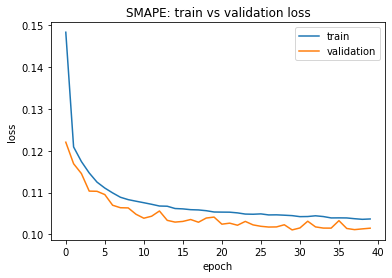

RMSE score for  NO2 : 8.196887687365546
SMAPE score for  NO2 : 0.9544292308293827

RMSE score for  NOX as NO2 : 5.231772600476837
SMAPE score for  NOX as NO2 : 0.5290844126979004

RMSE score for  PM2.5 : 6.028778397545844
SMAPE score for  PM2.5 : 0.7467068404430652

RMSE score for  PM10 : 6.010567226707226
SMAPE score for  PM10 : 1.3874709249786297

RMSE score: 23.48432407341905
SMAPE score: 0.49024930851258647



In [16]:
# plot the loss plot train and validate
import numpy as np
from math import sqrt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('SMAPE: train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# predicting PM10
predicted_y = model.predict(X_Test).reshape(-1,4)

# De-normalising predicted y data
predicted_y = i_sc.inverse_transform(predicted_y)

# De-normalising actual y data
y_actual = i_sc.inverse_transform(y_Test.reshape(-1,4))

# replace negative values with zero
temp = predicted_y.copy()
temp[temp<0] = 0
predicted_y = temp

pollutants = ["NO2","NOX as NO2","PM2.5","PM10"]

for i in range(0,predicted_y.shape[1]):

    # calculating RMSE
    rmse_score = sqrt(mean_squared_error(y_actual[i], predicted_y[i]))
    print('RMSE score for ',pollutants[i],':',rmse_score)
    # calculating SMAPE
    smape_score = smape(y_actual[i],predicted_y[i])
    print('SMAPE score for ',pollutants[i],':',smape_score)
    print()

# calculating RMSE
rmse_score = sqrt(mean_squared_error(y_actual, predicted_y))
print('RMSE score:',rmse_score)
# calculating SMAPE
smape_score = smape(y_actual,predicted_y)
print('SMAPE score:',smape_score)
print()

In [ ]:
# load model
Load_Model = False

model_name = 'Damp_Comp_Model_SMAPE_0.2997_DateTime_20201119_220728'

if Load_Model == True:
    from tensorflow import keras
    load_model_path = r"G:\Uppsala Docs\period5&6\Models"
    model = keras.models.load_model(os.path.join(load_model_path,model_name),compile=False)
    print('model loaded: '+str(model_name))

In [18]:
# predict and evaluate
import os
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

# predicting PM10
predicted_y = model.predict(X_Test).reshape(-1,4)

# De-normalising predicted y data
predicted_y = i_sc.inverse_transform(predicted_y)

# De-normalising actual y data
y_actual = i_sc.inverse_transform(y_Test.reshape(-1,4))

pollutants = ["NO2","NOX as NO2","PM2.5","PM10"]
station_order = [18644,8780,8779,8781]

# replace negative values with zero
temp = predicted_y.copy()
temp[temp<0] = 0
predicted_y = temp

for i in range(0,len(station_order)):
    print("Processing station "+str(station_order[i])+':')
    # generate index values of station
    lowerbound = int(predicted_y.shape[0]/4)*i
    upperbound = int(predicted_y.shape[0]/4)*(i+1)
    # generate date
    rng = pd.date_range('2019-10-01 00:00:00', periods=int(len(predicted_y)/4), freq='H')
    # convert to df
    station_df = pd.DataFrame({'Start': rng,
                               pollutants[0] : predicted_y[lowerbound:upperbound][:,0],
                               pollutants[1] : predicted_y[lowerbound:upperbound][:,1],
                               pollutants[2] : predicted_y[lowerbound:upperbound][:,2],
                               pollutants[3] : predicted_y[lowerbound:upperbound][:,3]})
    # save the file
    save_path = r'G:\Uppsala Docs\period5&6\Submissionfiles\Predictions_each_stations'
    filename = str(station_order[i])+'.csv'
    station_df.to_csv(os.path.join(save_path,filename), index=False)
    print("Saved station "+str(station_order[i])+':')


for i in range(0,predicted_y.shape[1]):

    # calculating RMSE
    rmse_score = sqrt(mean_squared_error(y_actual[i], predicted_y[i]))
    print('RMSE score for ',pollutants[i],':',rmse_score)
    # calculating SMAPE
    smape_score = smape(y_actual[i],predicted_y[i])
    print('SMAPE score for ',pollutants[i],':',smape_score)
    print()

Processing station 18644:
Saved station 18644:
Processing station 8780:
Saved station 8780:
Processing station 8779:
Saved station 8779:
Processing station 8781:
Saved station 8781:
RMSE score for  NO2 : 8.196887687365546
SMAPE score for  NO2 : 0.9544292308293827

RMSE score for  NOX as NO2 : 5.231772600476837
SMAPE score for  NOX as NO2 : 0.5290844126979004

RMSE score for  PM2.5 : 6.028778397545844
SMAPE score for  PM2.5 : 0.7467068404430652

RMSE score for  PM10 : 6.010567226707226
SMAPE score for  PM10 : 1.3874709249786297



In [17]:
# save model or load old model

Save_Model = True

if Save_Model == True:
    import time
    timestr = time.strftime("%Y%m%d_%H%M%S")
    # save model
    model_path = r"G:\Uppsala Docs\period5&6\Models\Damp_Comp_Model_SMAPE_"+str(round(smape_score,4))+'_DateTime_'+str(timestr)
    model.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:\Uppsala Docs\period5&6\Models\Damp_Comp_Model_SMAPE_0.4902_DateTime_20201120_140124\assets


In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(y_actual[0:24,0], color = 'black', label = 'NO2 Actual')
pyplot.plot(predicted_y[0:24,0], color = 'red', label = 'NO2 Predicted')
pyplot.title('NO2 Actual vs Predicted')
pyplot.xlabel('Time')
pyplot.ylabel('ug/m3')
pyplot.legend()
pyplot.show()

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(y_actual[0:24,1], color = 'black', label = 'NOX as NO2 Actual')
pyplot.plot(predicted_y[0:24,1], color = 'red', label = 'NOX as NO2 Predicted')
pyplot.title('NOX as NO2 Actual vs Predicted')
pyplot.xlabel('Time')
pyplot.ylabel('ug/m3')
pyplot.legend()
pyplot.show()

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(y_actual[0:24,2], color = 'black', label = 'PM2.5 Actual')
pyplot.plot(predicted_y[0:24,2], color = 'red', label = 'PM2.5 Predicted')
pyplot.title('PM2.5 Actual vs Predicted')
pyplot.xlabel('Time')
pyplot.ylabel('ug/m3')
pyplot.legend()
pyplot.show()

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(y_actual[0:24,3], color = 'black', label = 'PM10 Actual')
pyplot.plot(predicted_y[0:24,3], color = 'red', label = 'PM10 Predicted')
pyplot.title('PM10 Actual vs Predicted')
pyplot.xlabel('Time')
pyplot.ylabel('ug/m3')
pyplot.legend()
pyplot.show()